## 使用VGG对猫和狗的图像进行分类
本例使用函数API构建网络。测试时不将网络中的全连接层换成卷积层，并且测试时使用的图片size仍为$224\times224$
### 样例
尺寸不同的RGB三通道彩色图片，分为猫和狗两类
### 标签
* 0: Cats
* 1: Dogs

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 导入数据
### 下载数据
本例使用的数据集是Kaggle的**Dogs vs. Cats**数据集的子数据集(Provided by Microsoft Research)。原数据集共300万条数据，其中可用的有2万5千条，取其中3000条作为本例的数据集：
* **训练集(Training Set)**：2000条
    * **Cats**：1000条
    * **Dogs**：1000条
* **测试集/验证集(Test Set/Validation Set)**：1000条
    * **Cats**：500条
    * **Dogs**：500条

首先将数据下载到本地，并解压到同文件夹中data路径下。[数据下载链接](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)

In [2]:
base_dir = os.path.join('data', 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### 获取各数据集各种样本的样本数

In [3]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [4]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### 设置BATCH_SIZE以及IMG_SHAPE
* **BATCH_SIZE**：一个Batch中图片的数量
* **IMG_SHAPE**：首先需要将尺寸不同的图片处理成尺寸相同的图片，这里的``IMG_SHAPE``即处理后的图片高和宽的像素数

In [5]:
BATCH_SIZE = 256  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 224  # Our training data consists of images with width of 150 pixels and height of 150 pixels

### 图像数据预处理
图像数据在传入到网络中之前，必须进行预处理，格式化为适当的浮点张量(Floating Point Tensors)。处理图像的步骤包括：
* 从磁盘中读取图像
* 解码这些图像的内容，并根据其RGB内容将其转换为适当的网格格式(Grid Format)
* 把它们转换成浮点张量
* 将张量从0到255之间的值重新调整为0到1之间的值，因为神经网络喜欢处理较小的输入值。

这里使用``tf.keras.preprocessing.image.ImageDataGenerator``类对图像数据进行处理。API中对此类的描述为：
> Generate batches of tensor image data with real-time data augmentation.

首先对训练集和测试集分别生成两个实例``train_image_generator``和``validation_image_generator``

API中对``rescale``参数的描述为：
> rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

In [6]:
train_image_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_image_generator = ImageDataGenerator(rescale=1./255)

在生成训练集和测试集的``ImageDataGenerator``实例之后，使用``flow_from_directory``方法从磁盘中载入图片，并进行``rescale``、``resize``等操作。
此方法用到的5个参数的功能分别为：
* **batch_size**: Size of the batches of data (default: 32).
* **directory**: string, path to the target directory. It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator.
* **shuffle**: Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.
* **target_size**: Tuple of integers ``(height, width)``, default: ``(256, 256)``. The dimensions to which all images found will be resized.
* **class_mode**: One of ``"categorical"``, ``"binary"``, ``"sparse"``, ``"input"``, or ``None``. Default: ``"categorical"``. Determines the type of label arrays that are returned:
    * **``"categorical"``** will be 2D one-hot encoded labels
    * **``"binary"``** will be 1D binary labels,
    * **``"sparse"``** will be 1D integer labels,
    * **``"input"``** will be images identical to input images (mainly used to work with autoencoders).
    * If **``None``**, no labels are returned (the generator will only yield batches of image data, which is useful to use with ``model.predict_generator()``). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of ``directory`` for it to work correctly.
    
还有一个非常重要的参数为：
* **classes**: Optional list of class subdirectories (e.g. `['dogs', 'cats']`). Default: None. If not provided, the list of classes will be automatically inferred from the subdirectory names/structure under `directory`, where each subdirectory will be treated as a different class (and the order of the classes, which will map to the label indices, will be alphanumeric). The dictionary containing the mapping from class names to class indices can be obtained via the attribute `class_indices`.

其他参数详见[API中说明](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)。

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                           directory=train_dir, 
                                                           shuffle=True, 
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150) 
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

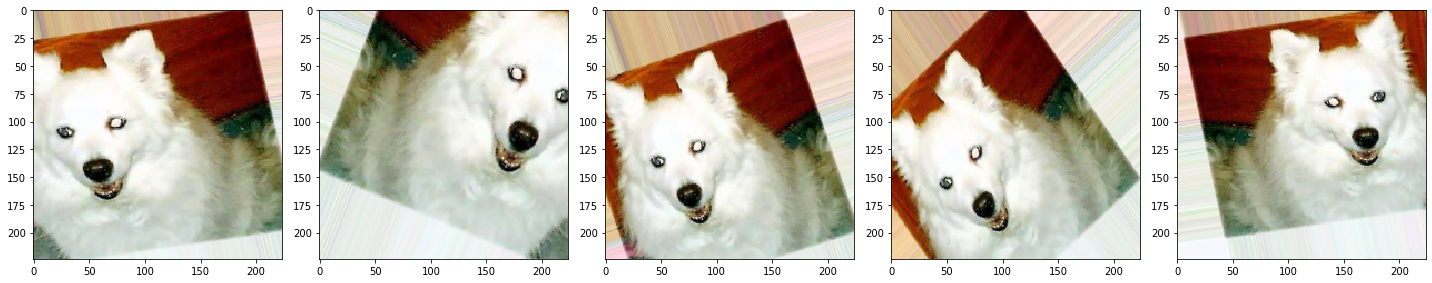

In [9]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## 构建模型
使用函数API构建网络

In [10]:
inputs = tf.keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))
h1 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3))(inputs)
h1 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(h1)

h2 = tf.keras.layers.MaxPooling2D(2, 2)(h1)
h2 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(h2)
h2 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(h2)

h3 = tf.keras.layers.MaxPooling2D(2,2)(h2)
h3 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(h3)
h3 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(h3)
h3 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(h3)

h4 = tf.keras.layers.MaxPooling2D(2,2)(h3)
h4 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(h4)
h4 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(h4)
h4 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(h4)

h5 = tf.keras.layers.MaxPooling2D(2,2)(h4)
h5 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(h5)
h5 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(h5)
h5 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(h5)

h6 = tf.keras.layers.MaxPooling2D(2,2)(h5)
h6 = tf.keras.layers.Flatten()(h6)
h6 = tf.keras.layers.Dropout(0.5)(h6)
h6 = tf.keras.layers.Dense(4096, activation='relu')(h6)
h6 = tf.keras.layers.Dropout(0.5)(h6)
h6 = tf.keras.layers.Dense(4096, activation='relu')(h6)
h6 = tf.keras.layers.Dense(1000, activation='relu')(h6)
outputs = tf.keras.layers.Dense(2, activation='softmax')(h6)

model = tf.keras.Model(inputs, outputs)

## 编译模型
可以使用多种损失函数以及``metrics``对模型进行编译（另一种方法见注释掉的代码）。

``tf.keras.optimizers.Adam()``的``learning_rate``这里使用默认值0.001。若使用0.01则会训练出一枚质地均匀的硬币。。。

In [11]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])
# model.compile(loss=tf.keras.losses.binary_crossentropy,
#              optimizer=tf.keras.optimizers.Adam(),
#              metrics=[tf.keras.metrics.binary_accuracy])

### 使用``model.summary()``方法查看网络中每一层以及每层的参数数量

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

## 训练模型
### 定义回调
Keras中的回调是在训练期间（在epoch开始时，batch结束时，epoch结束时等）在不同点调用的对象，可用于实现以下行为：

* 在培训期间的不同时间点进行验证（超出内置的每个时期验证）
* 定期检查模型或超过某个精度阈值
* 在训练似乎平稳时改变模型的学习率
* 在训练似乎平稳时对顶层进行微调
* 在培训结束或超出某个性能阈值时发送电子邮件或即时消息通知等等。

可使用的部分内置回调有：

* **ModelCheckpoint**：定期保存模型。
* **EarlyStopping**：当训练不再改进验证指标时停止培训。
* **TensorBoard**：定期编写可在TensorBoard中显示的模型日志（更多细节见“可视化”）。
* **CSVLogger**：将丢失和指标数据流式传输到CSV文件。


In [13]:
EPOCHS = 200

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # 是否有提升关注的指标
        monitor='val_accuracy',
        # 不再提升的阈值
        min_delta=1e-2,
        # 2个epoch没有提升就停止
        patience=3,
        verbose=1)
]

history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
                              validation_data=val_data_gen,
                              validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
#                               callbacks=callbacks,
                              verbose=1)

Epoch 1/200
8/8 [==============================] - 1039s 130s/step - loss: 7.2372 - accuracy: 0.4945 - val_loss: 7.8702 - val_accuracy: 0.5000
Epoch 2/200
8/8 [==============================] - 945s 118s/step - loss: 8.0607 - accuracy: 0.5000 - val_loss: 7.8702 - val_accuracy: 0.5000
Epoch 3/200
8/8 [==============================] - 923s 115s/step - loss: 8.0542 - accuracy: 0.5000 - val_loss: 7.8702 - val_accuracy: 0.5000
Epoch 4/200
8/8 [==============================] - 1912s 239s/step - loss: 8.0381 - accuracy: 0.5000 - val_loss: 7.8702 - val_accuracy: 0.5000
Epoch 5/200
8/8 [==============================] - 923s 115s/step - loss: 8.0736 - accuracy: 0.5000 - val_loss: 7.8702 - val_accuracy: 0.5000
Epoch 6/200
8/8 [==============================] - 1485s 186s/step - loss: 8.0623 - accuracy: 0.5000 - val_loss: 7.8702 - val_accuracy: 0.5000
Epoch 7/200
8/8 [==============================] - 977s 122s/step - loss: 8.0671 - accuracy: 0.5000 - val_loss: 7.8702 - val_accuracy: 0.5000
Epo

KeyboardInterrupt: 

# 可视化训练结果
进行早停回调，因此只训练了11epochs便停止训练。

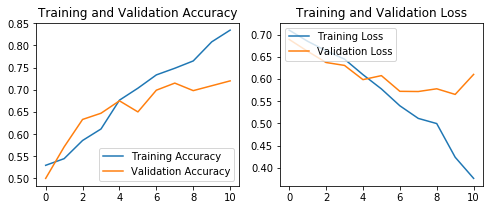

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## 使用``model.get_layer``方法得到网络中想要的层
``model.get_layer``的参数为：
* **name**: String, name of layer.
* **index**: Integer, index of layer.

之后使用``get_weights``方法查看此层的参数。

In [ ]:
# 通过model.summary()获取layer名称，查看第一个卷积层的参数，包括kernel的参数以及偏置值bias的参数
for w in model.get_layer('conv2d_4').get_weights():
    print(w.shape)

In [39]:
# 第2层（index == 1）为池化层，没有参数
model.get_layer(index=1).get_weights()  # Max Pooling Layer

[]

In [40]:
# 第二个卷积层
for w in model.get_layer(index=2).get_weights():
    print(w.shape)

(3, 3, 32, 64)
(64,)
